# 年龄性别预测比赛
## 数据概览
### 训练数据 每个设备对应的性别、年龄段【deviceid_train.tsv】

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import numpy as np
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
class DeviceGenderAge():
    def __init__(self, device, gender, age):
        self.device = device
        self.gender = int(gender)
        self.age = int(age)
    def __str__(self):
        return "device: {0}, gender: {1}, age: {2}".format(self.device, self.gender, self.age)
device_gender_age_train_list = []
with open("Demo/deviceid_train.tsv", "r", encoding="utf-8") as f:
    for line in f.readlines():
        line = line.strip()
        items = line.split("\t")
        device = DeviceGenderAge(items[0], items[1], items[2])
        device_gender_age_train_list.append(device)

print("一个数据样例:")
print(device_gender_age_train_list[50])

一个数据样例:
device: 53bb60ec1eb01562b047ae6a56c0b943, gender: 1, age: 7


训练集大小50000


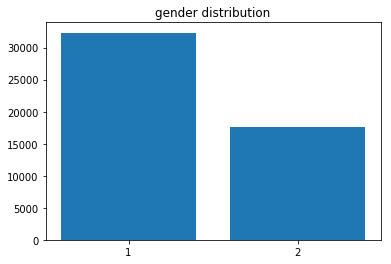

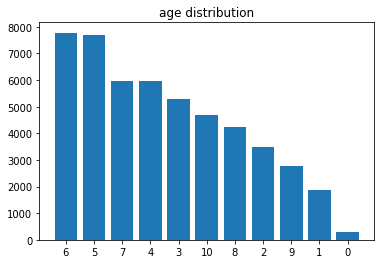

In [3]:
print("训练集大小{}".format(len(device_gender_age_train_list)))

gender_map = {}
age_map = {}
for item in device_gender_age_train_list:
    gender_map[item.gender] = gender_map.get(item.gender, 0) + 1
    age_map[item.age] = age_map.get(item.age, 0) + 1
gender_list = sorted(gender_map.items(), key=lambda x: x[1], reverse=True)
age_list = sorted(age_map.items(), key=lambda x: x[1], reverse=True)
plt.bar(range(len(gender_list)), [x[1] for x in gender_list], tick_label = [x[0] for x in gender_list])
plt.title("gender distribution")
plt.show()
plt.bar(range(len(age_list)), [x[1] for x in age_list], tick_label = [x[0] for x in age_list])
plt.title("age distribution")
plt.show()

In [4]:
devices_in_traindata_set = set([x.device for x in device_gender_age_train_list])

### 设备数据 每个设备上的应用安装列表，设备应用名都进行了hash处理【deviceid_packages.tsv】

In [5]:
device_packages_map = {}
with open("Demo/deviceid_packages.tsv", "r", encoding="utf-8") as f:
    for line in f.readlines():
        line = line.strip()
        items = line.split("\t")
        device_packages_map[items[0]] = items[1].split(",")


#### 看看统计数据

In [6]:
mean_app_per_device = np.mean([len(value) for key, value in device_packages_map.items()])
print("平均每个手机安装{}款app".format(mean_app_per_device))

平均每个手机安装10.528400731502742款app


In [7]:
app_set = set()
for value in device_packages_map.values():
    for item in value:
        app_set.add(item)
print("一共{}款不同的app".format(len(app_set)))

一共35000款不同的app


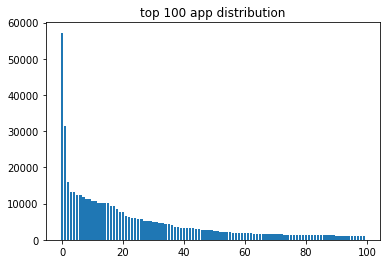

In [8]:
app_count_map = {}
for value in device_packages_map.values():
    for item in value:
        app_count_map[item] = app_count_map.get(item, 0) + 1
top_app = sorted(app_count_map.items(), key=lambda x: x[1], reverse=True)[:100]
plt.bar(range(len(top_app)), [x[1] for x in top_app])
plt.title("top 100 app distribution")
plt.show()

In [9]:
top_app_set = set([x[0] for x in top_app])

### 应用数据 每个设备上各个应用的打开、关闭行为数据【deviceid_package_start_close.tsv】

In [10]:
# 每台手机，各应用使用频次、时间统计
device_app_open_close_map = {}
class Container():
    def __init__(self):
        self.freq = 0
        self.time = 0
    def __str__(self):
        return "freq: {0}, time: {1}".format(self.freq, self.time)
with open("Demo/deviceid_package_start_close.tsv", "r", encoding="utf-8") as f:
    for line in f.readlines():
        items = line.strip().split("\t")
        if items[1] not in top_app_set:
            continue
        time_delta = (int(items[3]) - int(items[2])) // 1000
        
        device_app_open_close_map[items[0]] = device_app_open_close_map.get(items[0], {})
        device_app_open_close_map[items[0]][items[1]] = device_app_open_close_map[items[0]].get(items[1], Container())
        device_app_open_close_map[items[0]][items[1]].freq += 1
        device_app_open_close_map[items[0]][items[1]].time += time_delta


In [11]:
device_app_open_close_map["f39d80ff140836ed76b226ae3b23ada4"]["07e967d75aab2f6a52c558695a572a7c"].freq
device_app_open_close_map["f39d80ff140836ed76b226ae3b23ada4"]["07e967d75aab2f6a52c558695a572a7c"].time
print("随机抽取一个人，一个app，它的使用次数: {}，使用时间: {}"
      .format(
          device_app_open_close_map["f39d80ff140836ed76b226ae3b23ada4"]["07e967d75aab2f6a52c558695a572a7c"].freq,
          device_app_open_close_map["f39d80ff140836ed76b226ae3b23ada4"]["07e967d75aab2f6a52c558695a572a7c"].time))

随机抽取一个人，一个app，它的使用次数: 1，使用时间: 35


### 机型数据 每个设备的品牌和型号【deviceid_brand.tsv】

In [12]:
device_factory_model_map = {}
with open("Demo/deviceid_brand.tsv", "r", encoding="utf-8") as f:
    for line in f.readlines():
        line = line.strip()
        items = line.split()
        device_factory_model_map[items[0]] = (items[1], items[2])
        
print("某个人: {}的手机是: {}，型号是: {}".format(
    "f39d80ff140836ed76b226ae3b23ada4",
    device_factory_model_map["f39d80ff140836ed76b226ae3b23ada4"][0],
    device_factory_model_map["f39d80ff140836ed76b226ae3b23ada4"][1]
))
# 手机厂商_id映射
factory_id_map = {}
# 手机型号_id映射
model_id_map = {}
for key, value in enumerate(set([x[0] for x in device_factory_model_map.values()])):
    factory_id_map[value] = key
    
for key, value in enumerate(set([x[1] for x in device_factory_model_map.values()])):
    model_id_map[value] = key


某个人: f39d80ff140836ed76b226ae3b23ada4的手机是: samsung，型号是: GT-N7105


### APP数据 每个应用的类别信息【package_label.tsv】

In [13]:
app_info_map = {}
with open("Demo/package_label.tsv", "r", encoding="utf-8") as f:
    for line in f.readlines():
        line = line.strip()
        items = line.split()
        app_info_map[items[0]] = (items[1], items[2])
print("某app: {}是: {}类目中的: {}".format(
    "6b812b3636e43508a3db2a3537c9a654",
    app_info_map["6b812b3636e43508a3db2a3537c9a654"][0],
    app_info_map["6b812b3636e43508a3db2a3537c9a654"][1]
))

某app: 6b812b3636e43508a3db2a3537c9a654是: 体育类目中的: 体育资讯


## 准备训练数据
由于数据挺多，所以把训练数据输出至文件

In [14]:
def getAppInstallInfo(device):
    """
    返回top100款app的使用情况。
    如果没有安装，则返回[0, 0]
    如有安装，则返回[使用次数，平均时长]
    """
    appInstallInfo = device_app_open_close_map.get(device)
    if not appInstallInfo:
        return [0] * 200
    buffer = [0 for i in range(200)]
    index = 0
    for app in top_app_set:
        container = appInstallInfo.get(app)
        if container:
            buffer[index] = container.freq
            index += 1
            buffer[index] = container.time // container.freq
            index += 1
        else:
            index += 2
    return buffer

def getFactoryInfo(device):
    """
    返回手机厂商id和手机型号id
    如果没搜索到，则返回[-1, -1]
    """
    factoryInfo = device_factory_model_map.get(device)
    if not factoryInfo:
        return [-1, -1]
    return [factory_id_map.get(factoryInfo[0]), model_id_map.get(factoryInfo[1])]


with open("train.data", "w", encoding="utf-8") as f:
    f.write("gender,age," + ",".join([str(i) for i in range(202)])+ "\n")
    for person in device_gender_age_train_list:
        line = [person.gender, person.age]
        
        appInstallInfoList = getAppInstallInfo(person.device)
        line.extend(appInstallInfoList)
        
        factoryInfoList = getFactoryInfo(person.device)
        line.extend(factoryInfoList)
        
        f.write(",".join([str(x) for x in line]) + "\n")
        


## 准备预测数据

In [15]:
with open("Demo/deviceid_test.tsv", "r", encoding="utf-8") as fi:
    users = [x.strip() for x in fi.readlines()]
with open("test.data", "w", encoding="utf-8") as f:
    f.write(",".join([str(i) for i in range(202)]) + "\n")
    for device in users:
        line = []
        
        appInstallInfoList = getAppInstallInfo(device)
        line.extend(appInstallInfoList)
        
        factoryInfoList = getFactoryInfo(device)
        line.extend(factoryInfoList)
        f.write(",".join([str(x) for x in line]) + "\n")

## 训练模型
(后面用其他分类器替代SVC了，它又慢又不好)

In [16]:
#train_df = pd.read_csv("train.data")

In [17]:
# y_gender = train_df["gender"]
# y_age = train_df["age"]
# train_df.drop(["gender", "age"], axis=1,inplace=True)

In [18]:
# svc_age_model = LinearSVC()
# svc_age_model.fit(train_df, y_age)
# svc_age_model.score(train_df, y_age)

In [19]:
# svc_gender_model = LinearSVC()
# svc_gender_model.fit(train_df, y_gender)
# svc_gender_model.score(train_df, y_gender)

## 预测模型

In [20]:
# test_df = pd.read_csv("test.data")

In [21]:
# predict_age = svc_age_model.predict(test_df)

In [22]:
# predict_gender = svc_gender_model.predict(test_df)

In [23]:
# predict_gender

## 输出结果

In [24]:
# with open("Demo/deviceid_test.tsv", "r", encoding="utf-8") as fi:
#     users = [x.strip() for x in fi.readlines()]
# with open("result.csv", "w", encoding="utf-8") as f:
#     f.write("DeviceID,1-0,1-1,1-2,1-3,1-4,1-5,1-6,1-7,1-8,1-9,1-10,2-0,2-1,2-2,2-3,2-4,2-5,2-6,2-7,2-8,2-9,2-10\n")
#     for i in range(len(users)):
#         predict = [0.0 for i in range(22)]
#         gender = predict_gender[i]
#         age = predict_age[i]
#         predict[(gender-1) * 11 + age] = 1.0
#         f.write(users[i]+"," + ",".join([str(x) for x in predict]) + "\n")
        

## 进阶
看到用线性svm，基于原始特征跑出来的结果很糟糕

### 尝试1.标准化与分段 

可能是因为像[app使用次数][平均使用时间]这种特征，取值范围太大所导致。所以，这里分别试试标准化，和分段化，看看哪种效果更好。

In [25]:
# train_df = pd.read_csv("train.data")
# columns = ["{}".format(x) for x in range(0, 200)]
# train_df[columns].describe()

看一下上表，筛选出了奇数命名的列。它们是top100常用app中每个用户的平均使用时间。

均值较大，方差也大，先试试标准化

In [26]:
# train_df[columns] = (train_df[columns] - train_df[columns].mean()) / train_df[columns].std()

In [27]:
# train_df[columns].describe()

In [28]:
# y_gender = train_df["gender"]
# y_age = train_df["age"]
# train_df.drop(["gender", "age"], axis=1,inplace=True)

# svc_age_model = LinearSVC()
# svc_age_model.fit(train_df, y_age)
# svc_age_model.score(train_df, y_age)

提升不是很明显，下面再试试分段

In [29]:
# train_df = pd.read_csv("train.data")
# columns = ["{}".format(x) for x in range(0, 200)]
# train_df[columns] = train_df[columns].apply(lambda x: pd.cut(x, 10, labels=False))

In [30]:
# y_gender = train_df["gender"]
# y_age = train_df["age"]
# train_df.drop(["gender", "age"], axis=1,inplace=True)

# svc_age_model = LinearSVC()
# svc_age_model.fit(train_df, y_age)
# svc_age_model.score(train_df, y_age)

效果更不好。看了下数据分布，的确不适用于分段

### 尝试2.特征变换取对数


In [31]:
# train_df = pd.read_csv("train.data")
# columns = ["{}".format(x) for x in range(0, 200)]
# train_df[columns].describe()

In [32]:
# columns = ["{}".format(x) for x in range(0, 200)]
# train_df[columns] = train_df[columns].apply(lambda x: np.log(x + 1))
# train_df[columns].describe()

In [33]:
# y_gender = train_df["gender"]
# y_age = train_df["age"]
# train_df.drop(["gender", "age"], axis=1,inplace=True)

# svc_age_model = LinearSVC()
# svc_age_model.fit(train_df, y_age)
# svc_age_model.score(train_df, y_age)

### 尝试3.降维

In [34]:
# train_df = pd.read_csv("train.data")
# columns = ["{}".format(x) for x in range(0, 200)]
# train_df[columns].describe()

In [35]:
# pca = PCA(n_components="mle", svd_solver ="full")
# pca.fit(train_df[columns])

In [36]:
# result = pca.transform(train_df[columns])

In [37]:
# columns_pca = [str(x) + "_pac" for x in range(result.shape[1])]
# train_df = pd.concat([train_df, pd.DataFrame(columns=columns_pca)])
# train_df[columns_pca] = result

In [38]:
# train_df[columns_pca].describe()

In [39]:
# y_gender = train_df["gender"]
# y_age = train_df["age"]
# train_df.drop(["gender", "age"] + columns, axis=1,inplace=True)

# svc_age_model = LinearSVC()
# svc_age_model.fit(train_df, y_age)
# svc_age_model.score(train_df, y_age)

总体看来，只有取对数有些提升，但提升有限。

### 引入新的特征
从上面的结果看出，是预测年龄拖了后腿。

所以试试把app类型加入进来。

In [40]:
packages_label_map = {}
with open("Demo/package_label.tsv", "r", encoding="utf-8") as f:
    for line in f.readlines():
        line = line.strip()
        items = line.split("\t")
        packages_label_map[items[0]] = items[1]

packages_label_map = {k:v for k, v in packages_label_map.items() if k in top_app_set}
packages_label_map

{'1896072db9ce6406febfc17f681c2086': '社交',
 '1cd8e0a97bf3552196f0f60eb3566ac7': '金融',
 '200cf557b3703944f1f68af08484d2bd': '系统工具',
 '2338f5519ae89cb819360870c849ac62': '移动购物',
 '2c94bf3242575e85879b036c109b39ea': '摄影摄像',
 '4fa7fb86712941bb3fab15596e081b0a': '金融',
 '4fc981a85c96ef6f91b8123b179e671c': '金融',
 '616120feb399049e89585756e0cfc4d1': '系统工具',
 '79eeda5f4c7fd2a0d483dc3d46fa5b3b': '实用工具',
 '8574dff94054503ee7f7986378e21118': '移动购物',
 '8c8544b6c129ad4a431be753143ed1c3': '应用管理',
 '9bc5b0fe46aa2192f199df1af00639c8': 'TAB(桌面游戏)',
 'b2d3e3faa159e396f4408a3c3aab7970': '系统工具',
 'dd23bbcd2da4282d178ca4e3646cbb00': '其它',
 'de54c4c46133bd8e06c5e2de6a38e846': '移动购物',
 'fc4b11cd2f4db02b2fb39f372b3ef905': '输入法',
 'fd6cc9bde865fe8cbf771d2f3f000770': '系统工具'}

我惊奇的发现，app类型表是不全的，我统计的top100热门app，只有17款被收录了类型信息。

所以只能换一种方式来引入新特征：加入每个用户，对各类型app的喜好强弱

先看下一共有多少个一级分类，多少个二级分类

In [41]:
label_lv1_set = set()
label_lv2_set = set()
with open("Demo/package_label.tsv", "r", encoding="utf-8") as f:
    for line in f.readlines():
        line = line.strip()
        items = line.split("\t")
        packages_label_map[items[0]] = items[1]
        label_lv1_set.add(items[1])
        label_lv2_set.add(items[2])
"一共有{}个一级类别，和{}个二级类别".format(str(len(label_lv1_set)), str(len(label_lv2_set)))


'一共有45个一级类别，和288个二级类别'

用这45个一级类别创建新特征，每个用户对这45个类别的喜好程度，由app打开次数决定

device_label_hot_map

key: device, value:[label1, label2, ..., label45]

In [42]:
label_lv1_list = list(label_lv1_set)
device_label_hot_map = {}

# 所有的用户id
with open("Demo/deviceid_test.tsv", "r", encoding="utf-8") as fi:
    users = [x.strip() for x in fi.readlines()]
device_train_and_test_set = devices_in_traindata_set | set(users)

with open("Demo/deviceid_package_start_close.tsv", "r", encoding="utf-8") as f:
    for line in f.readlines():
        items = line.strip().split("\t")
        if items[0] not in device_train_and_test_set:
            continue
            
        device_label_hot_map[items[0]] = device_label_hot_map.get(items[0], [0]*45)
        label = packages_label_map.get(items[1], None)
        if label:
            index = label_lv1_list.index(label)
            device_label_hot_map[items[0]][index] += 1


组合新旧特征，重新创建训练语料

In [43]:
train_df = pd.read_csv("train.data")
train_df.head(5)

,gender,age,0,1,2,3,4,5,6,7,...,192,193,194,195,196,197,198,199,200,201
0,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,696,948
1,1,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,673,1104
2,2,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,236,1671
3,1,4,0,0,0,0,0,0,0,0,...,0,0,9,158,0,0,0,0,673,1347
4,1,3,0,0,0,0,2,16,0,0,...,0,0,0,0,0,0,0,0,673,648


In [44]:
with open("train_1.data", "w", encoding="utf-8") as f:
    f.write("gender,age," + ",".join([str(i) for i in range(202+45)])+ "\n")
    for index in range(len(device_gender_age_train_list)):
        x = device_gender_age_train_list[index]
        new_features = device_label_hot_map[x.device]
        merged = train_df.loc[index].tolist() + new_features
        f.write(",".join([str(x) for x in merged]) + "\n")

In [45]:
train_df = pd.read_csv("train_1.data")
train_df.head(5)

,gender,age,0,1,2,3,4,5,6,7,...,237,238,239,240,241,242,243,244,245,246
0,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,5,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,3,0,0,0,0,2,16,0,0,...,0,0,0,0,0,0,0,0,0,0


创建包含新特征的预测语料

In [46]:
test_df = pd.read_csv("test.data")

with open("Demo/deviceid_test.tsv", "r", encoding="utf-8") as fi:
    users = [x.strip() for x in fi.readlines()]
with open("test_1.data", "w", encoding="utf-8") as f:
    f.write(",".join([str(i) for i in range(202+45)])+ "\n")
    for index in range(len(users)):
        new_features = device_label_hot_map[users[index]]
        merged = test_df.loc[index].tolist() + new_features
        f.write(",".join([str(x) for x in merged]) + "\n")

In [47]:
test_df = pd.read_csv("test_1.data")
test_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,237,238,239,240,241,242,243,244,245,246
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,23,102,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,54,4062,2,125,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,27,16,0,0,1,64,0,0,7,119,...,0,0,0,0,2,0,0,0,0,0


In [48]:
y_gender = train_df["gender"]
y_age = train_df["age"]
train_df.drop(["gender", "age"], axis=1,inplace=True)

X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(train_df, y_age, test_size=0.33, random_state=42)
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(train_df, y_gender, test_size=0.33, random_state=42)

In [49]:
dtc_age = DecisionTreeClassifier(max_depth=4)
dtc_age.fit(X_train_age, y_train_age)
dtc_age.score(X_test_age, y_test_age)

0.20763636363636365

In [50]:
dtc_gender = DecisionTreeClassifier(max_depth=8)
dtc_gender.fit(X_train_gender, y_train_gender)
dtc_gender.score(X_test_gender, y_test_gender)

0.6495151515151515

In [51]:
gbc_age = GradientBoostingClassifier(n_estimators=10)
gbc_age.fit(X_train_age, y_train_age)
gbc_age.score(X_test_age, y_test_age)

0.21745454545454546

In [52]:
gbc_gender = GradientBoostingClassifier(n_estimators=10)
gbc_gender.fit(X_train_gender, y_train_gender)
gbc_gender.score(X_test_gender, y_test_gender)

0.6481818181818182

偶然发现，决策树才是正确的选择！

改SVC为决策树

In [53]:
test_df = pd.read_csv("test_1.data")
predict_age = dtc_age.predict(test_df)
predict_gender = dtc_gender.predict(test_df)

with open("Demo/deviceid_test.tsv", "r", encoding="utf-8") as fi:
    users = [x.strip() for x in fi.readlines()]
with open("result.csv", "w", encoding="utf-8") as f:
    f.write("DeviceID,1-0,1-1,1-2,1-3,1-4,1-5,1-6,1-7,1-8,1-9,1-10,2-0,2-1,2-2,2-3,2-4,2-5,2-6,2-7,2-8,2-9,2-10\n")
    for i in range(len(users)):
        predict = [0.0 for i in range(22)]
        gender = predict_gender[i]
        age = predict_age[i]
        predict[(gender-1) * 11 + age] = 1.0
        f.write(users[i]+"," + ",".join([str(x) for x in predict]) + "\n")

### 试一下同时分类age与gender

训练

In [4]:
train_df = pd.read_csv("train_1.data")
y = train_df["age"] + ((train_df["gender"] -1) * 11)
train_df.drop(["gender", "age"], axis=1,inplace=True)
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.33, random_state=42)

In [55]:
dct = DecisionTreeClassifier(max_depth=10)
dct.fit(X_train, y_train)
dct.score(X_train, y_train), dct.score(X_test, y_test)

(0.18429850746268656, 0.1390909090909091)

In [8]:
gbc = GradientBoostingClassifier(n_estimators=5, max_depth=5)
gbc.fit(X_train, y_train)
gbc.score(X_train, y_train),gbc.score(X_test, y_test)

(0.21835820895522387, 0.1416969696969697)

In [58]:
gbc = GradientBoostingClassifier(n_estimators=50, max_depth=5)
gbc.fit(X_train, y_train)
gbc.score(X_train, y_train),gbc.score(X_test, y_test)

(0.40373134328358207, 0.13872727272727273)

In [59]:
gbc = GradientBoostingClassifier(n_estimators=100, max_depth=5)
gbc.fit(X_train, y_train)
gbc.score(X_train, y_train),gbc.score(X_test, y_test)

(0.49456716417910446, 0.1373939393939394)

In [64]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=5)
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train),gbc.score(X_test, y_test)

(0.15480597014925374, 0.1373939393939394)

预测

In [11]:
test_df = pd.read_csv("test_1.data")
predict_array = gbc.predict(test_df)

with open("Demo/deviceid_test.tsv", "r", encoding="utf-8") as fi:
    users = [x.strip() for x in fi.readlines()]
with open("result.csv", "w", encoding="utf-8") as f:
    f.write("DeviceID,1-0,1-1,1-2,1-3,1-4,1-5,1-6,1-7,1-8,1-9,1-10,2-0,2-1,2-2,2-3,2-4,2-5,2-6,2-7,2-8,2-9,2-10\n")
    for i in range(len(users)):
        predict = [0.0 for i in range(22)]
        index = predict_array[i]
        predict[index] = 1.0
        f.write(users[i]+"," + ",".join([str(x) for x in predict]) + "\n")

## 修改特征
到目前为止，结果并不好，推测是特征仍然不足。考虑到之前只使用了top100款app作为特征，现在想扩大范围，把所有app的使用情况都作为特征输入进去。

In [15]:
# 从开源的代码中学习到的方法
# 把每个用户安装的app列表，看做一篇文章，文章每个单词是一款app
# 然后就可以用count vectorizer 和 tfidf 提取特征了
deviceid_packages=pd.read_csv('Demo/deviceid_packages.tsv',sep='\t',names=['device_id','apps'])
deviceid_packages['apps']=deviceid_packages['apps'].apply(lambda x:x.split(','))
deviceid_packages['app_lenghth']=deviceid_packages['apps'].apply(lambda x:len(x))
deviceid_packages.head(5)

,device_id,apps,app_lenghth
0,00009270c4ec26e1d76f5d86847009c9,"[1896072db9ce6406febfc17f681c2086, 90cb852cf34...",3
1,000189ef5d5b951841d416a8c6c5b995,"[1896072db9ce6406febfc17f681c2086, 97d0422a331...",19
2,00026d79a6f0955fc860947724e24765,[c33b35d6254ad9c0c238233eb97a6c60],1
3,0002e3afb8146bc08e40575e45f0eca6,"[1896072db9ce6406febfc17f681c2086, 07e967d75aa...",3
4,0004709a296f9b925ae283efe2f043e7,"[4538778ad75aa8ce61c9d13fb9cb661b, 86f9f299cdb...",16


In [21]:
# 有了上表后，就可以把apps列用CountVectorizer和Tfidf
apps = deviceid_packages["apps"].apply(lambda x: " ".join(x)).tolist()
//
vectorizer=CountVectorizer()
transformer=TfidfTransformer()
cntTf = vectorizer.fit_transform(apps)
tfidf=transformer.fit_transform(cntTf)
word=vectorizer.get_feature_names()
print("app特征，包含以下app: " + ",".join(word))
weight=tfidf.toarray()
print(weight)

app特征，包含以下app: 00001de888265b507927b24bc2ef2652,0002b5a7599da4996f1a93559bdbab95,000533a8532cde925ccb4d232c0c6453,0006d5218cb48df4b7035df5cb4c78ea,0006ebf20cb258c845991c5f28f6cbda,000ff845ed5b170f986d9b00f0b919e5,001016d53c89de63fcc81aff70f8b571,00109029d1c197730e38d3bc72014ce5,0013b6d971b3969107b63663b7961e24,0013dbb43e3e47141e54358b1e44b770,00147efd843a3c86ce4277b28d0de89a,0014bd26a0aeec28558b7da8fb15e73e,0016b6094f96aa68e09ab1da6ec4bc62,0017b1b37619d8a9bb78f62d2a657aac,0017c4daa01cd4b595513d1fe55bb1af,00180efeb56e1dce7e5ca192c31d8ac5,0019a56ee5676e20db0d4197c3649243,001c6e071ad0c1957579d4708f605ffb,001c970ec60feaffc6611eeb47d07b6f,001cd05f9087d09e3538152e48b2846f,0020d81d89367cda1414cb71318c2628,002166b32aa2dc9608edc3dcabfad9f1,002266cd0bb66b4324e7fde70db97a93,0022c2fbd3775b54571d57d8ecedd37d,00246ce684bb5c1a69b1101a4678bcd3,002d23335b07dedab06b9d2794a99cce,002fe007e660f1c13492686bf2fec6df,002ff41e33eb44e7a3f3d190d03ce96c,0033a00f7d3b40da159551ac37a4fa9d,0034621b42b155475c5462b5b65d

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
